# Quantizing Stable Diffusion for Faster Inference

This notebook investigates how **post-training quantization (PTQ)** can accelerate Stable Diffusion v1.5 while keeping image quality usable.  
We follow the key ideas from the paper **Q-Diffusion: Quantizing Diffusion Models**:

- Focus on quantizing the **UNet noise-prediction model**, the computational bottleneck.
- Use **timestep-aware activation calibration** (collecting min/max activation ranges across diffusion steps).
- Apply **fake quantization** (INT8, INT4, mixed precision) during inference to simulate low-bit execution.

Unlike the original Q-Diffusion implementation, which uses a custom diffusion codebase, 
we apply the same quantization concepts to the HuggingFace Diffusers version of Stable Diffusion v1.5.  
This allows us to perform realistic model-level and system-level analysis while keeping the project 
feasible within the course timeline.  
We evaluate:

- **Latency** (seconds / image)  
- **VRAM usage**  
- **Image quality** (CLIPScore)  
- **System-level performance** using an **M/M/1 queueing model**

This aligns with our project proposal: *“Dynamic quantization policies for Stable Diffusion under varying system loads.”*

In [1]:
# === Environment & device check ===
import torch, platform, os, time
from pprint import pprint

print("Python:", platform.python_version())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

mps_available = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
print("MPS available:", mps_available)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU:", torch.cuda.get_device_name(0))
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
elif mps_available:
    device = torch.device("mps")
    print("Using Apple M-series GPU (mps)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Final device:", device)


Python: 3.11.14
PyTorch: 2.6.0+cu124
CUDA available: True
MPS available: False
Using CUDA GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Final device: cuda


In [2]:
# === Install / import core libraries ===

from diffusers import StableDiffusionPipeline
from transformers import logging as hf_logging

import numpy as np
import math
from collections import defaultdict
from contextlib import contextmanager
from typing import Dict, List, Tuple
import gc

hf_logging.set_verbosity_error()
torch.set_grad_enabled(False)

In [3]:
# === Load Stable Diffusion v1.5 (baseline FP16/FP32 depending on device) ===
from diffusers import StableDiffusionPipeline
from transformers import logging as hf_logging

hf_logging.set_verbosity_error()
torch.set_grad_enabled(False)

MODEL_ID = "runwayml/stable-diffusion-v1-5"

# Use fp16 on GPU (CUDA or MPS), fp32 on CPU
if device.type in ("cuda", "mps"):
    sd_dtype = torch.float16
else:
    sd_dtype = torch.float32  # CPU cannot efficiently use fp16

pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=sd_dtype,
    safety_checker=None,  # ok for local academic use
)

pipe = pipe.to(device)

# Attention slicing helps on both CUDA and MPS
if device.type in ("cuda", "mps"):
    pipe.enable_attention_slicing("max")

print(
    "Pipeline loaded. UNet parameters:",
    sum(p.numel() for p in pipe.unet.parameters()) / 1e6,
    "M",
)
print("Pipeline dtype:", sd_dtype, "| device:", device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Pipeline loaded. UNet parameters: 859.520964 M
Pipeline dtype: torch.float16 | device: cuda


  0%|          | 0/20 [00:00<?, ?it/s]

Baseline FP16: 2 images, ~9.20 s / image


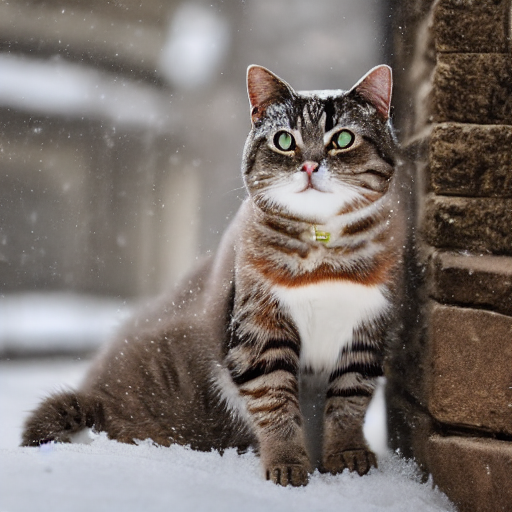

In [4]:
# === Simple image generation + timing helper ===
from PIL import Image
import random

@torch.inference_mode()
def generate_images(
    prompts: List[str],
    num_inference_steps: int = 30,
    guidance_scale: float = 7.5,
    height: int = 512,
    width: int = 512,
    seed: int = 42,
):
    """
    Generate images and measure latency.
    Returns: images, mean_latency_per_image (seconds).
    """
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)

    start = time.perf_counter()
    result = pipe(
        prompts,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        height=height,
        width=width,
        generator=generator,
    )
    end = time.perf_counter()
    images = result.images

    total_time = end - start
    mean_time = total_time / len(prompts)
    return images, mean_time

test_prompts = [
    "a photo of a cat in the snow, high quality, 4k",
    "a futuristic city at night, neon lights, cyberpunk style",
]

imgs, t = generate_images(test_prompts, num_inference_steps=20)
print(f"Baseline FP16: {len(test_prompts)} images, ~{t:.2f} s / image")
display(imgs[0])

## Calibration Procedure and Quantization Modes

### Timestep-Aware Calibration

Before applying quantization, we first calibrate the **UNet activations**:

1. Register forward hooks on every `Conv2d` module inside the UNet.  
2. Run Stable Diffusion on a small set of calibration prompts (e.g., surreal scenes) across several diffusion timesteps.  
3. Track the **minimum** and **maximum** activation values for each layer.  
4. Compute the activation **scale** for bit-width \(b\):

$$
\text{scale} = \frac{\max\left(|\text{min}|,\,|\text{max}|\right)}{2^{b-1} - 1}
$$

We use **symmetric per-tensor quantization** for both **INT8** and **INT4**.

This creates a simple **timestep-aware PTQ calibration**, similar to Q-Diffusion:  
the network is exposed to multiple timesteps so that quantization ranges match real inference behavior.

---

### Fake Quantization Hooks (INT8 / INT4 / Mixed)

We apply **fake quantization** at runtime using forward hooks rather than permanently modifying weights.

For each UNet `Conv2d` layer, the hook performs:

1. **Clamp activations** to:

$$
[-Q_{\max}\cdot \text{scale},\; Q_{\max}\cdot \text{scale}]
$$

2. **Quantize** values:

$$
a_q = \text{round}\!\left(\frac{a}{\text{scale}}\right)
$$

3. **Dequantize** back to float:

$$
a_{\text{dq}} = a_q \cdot \text{scale}
$$

This simulates **INT8/INT4 behavior** while keeping the pipeline numerically stable in FP16.

---

### Quantization Modes

- **FP16**  
  No quantization hooks (baseline).

- **INT8**  
  All UNet convolutions quantized to **8-bit** activations.

- **INT4**  
  All UNet convolutions quantized to **4-bit** activations  
  (more compression, but potentially more quality loss).

- **Mixed Precision**  
  A simple heuristic:
  - Downsample + mid blocks → **INT8**  
  - Upsample blocks → **INT4**

This imitates the mixed-precision strategy suggested by Q-Diffusion:  
more sensitive layers get more bits, less sensitive layers get fewer bits.


In [5]:
# === Collect UNet Conv2d modules (noise estimator) ===
import torch.nn as nn

def collect_unet_conv_modules(unet: nn.Module) -> List[nn.Module]:
    conv_modules = []
    for name, module in unet.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_modules.append((name, module))
    return conv_modules

unet = pipe.unet
conv_modules = collect_unet_conv_modules(unet)
print(f"Found {len(conv_modules)} Conv2d modules in UNet.")
print("First 5:", [name for name, _ in conv_modules[:5]])

Found 98 Conv2d modules in UNet.
First 5: ['conv_in', 'down_blocks.0.attentions.0.proj_in', 'down_blocks.0.attentions.0.proj_out', 'down_blocks.0.attentions.1.proj_in', 'down_blocks.0.attentions.1.proj_out']


In [6]:
# === Timestep-aware activation calibration (Q-Diffusion-style) ===
"""
Goal:
- Run the UNet over multiple timesteps and prompts.
- Record activation min/max for each Conv2d output.
- This approximates the time-step-aware calibration idea from Q-Diffusion
  (we expose the network to activations from different noise levels).
"""

activation_stats: Dict[str, Dict[str, torch.Tensor]] = {
    name: {"min": None, "max": None} for name, _ in conv_modules
}

def _make_calib_hook(name: str):
    def hook(_module, _inputs, output):
        if not torch.is_floating_point(output):
            return
        stats = activation_stats[name]
        out_min = output.min().detach()
        out_max = output.max().detach()
        if stats["min"] is None:
            stats["min"] = out_min
            stats["max"] = out_max
        else:
            stats["min"] = torch.minimum(stats["min"], out_min)
            stats["max"] = torch.maximum(stats["max"], out_max)
    return hook

# Register hooks
hooks = []
for name, module in conv_modules:
    hooks.append(module.register_forward_hook(_make_calib_hook(name)))

print("Calibration hooks registered.")

@torch.inference_mode()
def calibrate_unet(
    num_calib_prompts: int = 16,
    num_inference_steps: int = 20,
):
    """
    Run the full pipeline on some prompts to exercise the UNet at different timesteps.
    We don't need the images; we just want activations through UNet.
    """
    prompts = [
        f"a random object in a surreal landscape #{i}"
        for i in range(num_calib_prompts)
    ]
    _ = pipe(
        prompts,
        num_inference_steps=num_inference_steps,
        guidance_scale=7.5,
        height=512,
        width=512,
    )

    # Move stats to CPU and convert to floats
    for name in activation_stats:
        for key in ["min", "max"]:
            if activation_stats[name][key] is not None:
                activation_stats[name][key] = activation_stats[name][key].cpu().float()

    print("Calibration completed.")

calibrate_unet(num_calib_prompts=8, num_inference_steps=20)

# Remove calibration hooks (we'll add quantization hooks later)
for h in hooks:
    h.remove()
print("Calibration hooks removed.")

Calibration hooks registered.


  0%|          | 0/20 [00:00<?, ?it/s]

Calibration completed.
Calibration hooks removed.


In [7]:
# === Build per-module activation scales for n-bit quantization ===
"""
We use symmetric per-tensor activation quantization:

scale = max(|min|, |max|) / (2^(bits-1) - 1)

Later we will quantize-dequantize outputs:

a_q = round(clamp(a / scale, -Qmax, Qmax)) * scale
"""

def build_activation_scales(n_bits: int) -> Dict[str, float]:
    qmax = 2 ** (n_bits - 1) - 1
    scales = {}
    for name, stats in activation_stats.items():
        if stats["min"] is None or stats["max"] is None:
            # fallback if module wasn't hit in calibration
            scales[name] = 1.0
            continue
        m = float(stats["min"])
        M = float(stats["max"])
        max_abs = max(abs(m), abs(M))
        if max_abs < 1e-8:
            scales[name] = 1.0
        else:
            scales[name] = max_abs / qmax
    return scales

act_scales_int8 = build_activation_scales(8)
act_scales_int4 = build_activation_scales(4)

print("Example INT8 scales for first 5 convs:")
for name in list(act_scales_int8.keys())[:5]:
    print(name, "->", act_scales_int8[name])

Example INT8 scales for first 5 convs:
conv_in -> 0.11737204724409449
down_blocks.0.attentions.0.proj_in -> 0.05422613188976378
down_blocks.0.attentions.0.proj_out -> 0.09258120078740158
down_blocks.0.attentions.1.proj_in -> 0.04093873031496063
down_blocks.0.attentions.1.proj_out -> 0.061208169291338585


In [8]:
# === Attach fake-quantization hooks for INT8 / INT4 / mixed precision ===
"""
We now implement a context manager that:
- registers forward hooks that quantize-dequantize Conv2d outputs
- simulates INT8 / INT4 effects on activations, inspired by Q-Diffusion's PTQ design.
"""

def _make_quant_hook(name: str, n_bits: int, scales_dict: Dict[str, float]):
    qmax = 2 ** (n_bits - 1) - 1
    scale = scales_dict.get(name, 1.0)

    def hook(_module, _inputs, output):
        if not torch.is_floating_point(output):
            return output
        # symmetric fake quantization
        max_abs = qmax * scale
        out_clamped = torch.clamp(output, -max_abs, max_abs)
        out_int = torch.round(out_clamped / scale)
        return out_int * scale
    return hook

@contextmanager
def quantization_mode(
    mode: str = "fp16",
    int8_scales: Dict[str, float] = None,
    int4_scales: Dict[str, float] = None,
):
    """
    mode in {"fp16", "int8", "int4", "mixed"}.

    - fp16: no hooks (base pipeline).
    - int8: fake quantize all Conv2d activations to 8-bit.
    - int4: fake quantize all Conv2d activations to 4-bit.
    - mixed: example policy: int8 for early/down blocks, int4 for mid/up blocks.
    """
    hooks = []

    if mode == "fp16":
        # no hooks, just yield
        yield
        return

    for name, module in conv_modules:
        if "conv" not in name:
            # soft filter, but we already know these are convs
            pass

        if mode == "int8":
            h = module.register_forward_hook(
                _make_quant_hook(name, 8, int8_scales)
            )
            hooks.append(h)

        elif mode == "int4":
            h = module.register_forward_hook(
                _make_quant_hook(name, 4, int4_scales)
            )
            hooks.append(h)

        elif mode == "mixed":
            # Simple heuristic: down_blocks + mid -> int8, up_blocks -> int4
            if "up_blocks" in name:
                h = module.register_forward_hook(
                    _make_quant_hook(name, 4, int4_scales)
                )
            else:
                h = module.register_forward_hook(
                    _make_quant_hook(name, 8, int8_scales)
                )
            hooks.append(h)

    try:
        yield
    finally:
        for h in hooks:
            h.remove()

## Benchmarking Latency and VRAM

For each quantization mode (FP16, INT8, INT4, mixed), we run Stable Diffusion on a fixed set of prompts and measure:

- **Latency** (seconds per image)
- **Peak VRAM usage**
- **Visual comparison of sample outputs**

These metrics allow us to quantify the trade-offs introduced by quantization.


=== Benchmarking mode: fp16 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Mode=fp16 | mean time per image = 5.57s | peak VRAM ≈ 4501.5 MB

=== Benchmarking mode: int8 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Mode=int8 | mean time per image = 5.65s | peak VRAM ≈ 4501.5 MB

=== Benchmarking mode: int4 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Mode=int4 | mean time per image = 5.41s | peak VRAM ≈ 4501.5 MB

=== Benchmarking mode: mixed ===


  0%|          | 0/20 [00:00<?, ?it/s]

Mode=mixed | mean time per image = 7.29s | peak VRAM ≈ 4501.5 MB

=== Summary ===
{'fp16': {'latency': 5.566790174999994,
          'sample_image': <PIL.Image.Image image mode=RGB size=512x512 at 0x1DB34B3CA90>,
          'vram_mb': 4501.4580078125},
 'int4': {'latency': 5.414801249999982,
          'sample_image': <PIL.Image.Image image mode=RGB size=512x512 at 0x1DB34B4A610>,
          'vram_mb': 4501.4580078125},
 'int8': {'latency': 5.645796275000009,
          'sample_image': <PIL.Image.Image image mode=RGB size=512x512 at 0x1DCDE259D90>,
          'vram_mb': 4501.4580078125},
 'mixed': {'latency': 7.286047574999998,
           'sample_image': <PIL.Image.Image image mode=RGB size=512x512 at 0x1DB34B3ECD0>,
           'vram_mb': 4501.4580078125}}


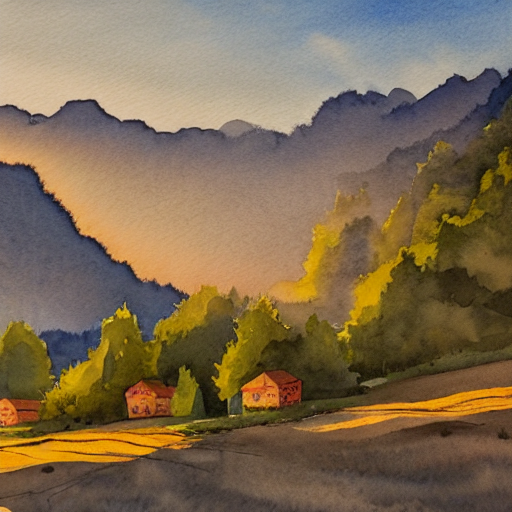

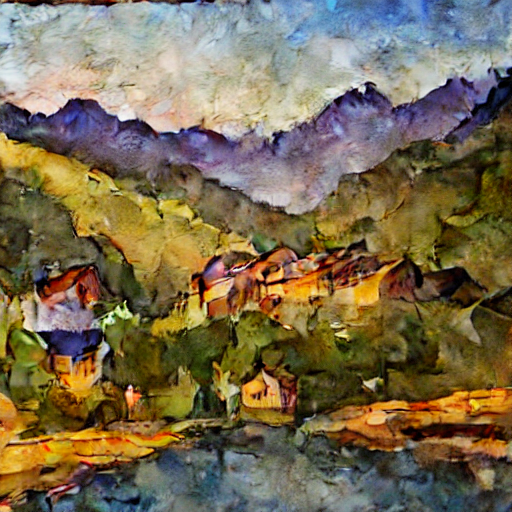

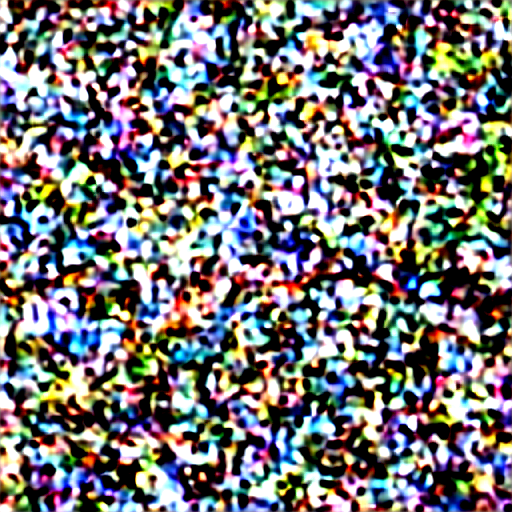

In [9]:
# === Benchmark function for different "quantization" modes ===
import psutil

def get_vram_mb():
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / (1024 ** 2)
    return 0.0

def reset_vram():
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def benchmark_mode(mode: str, prompts: List[str], steps: int = 20):
    print(f"\n=== Benchmarking mode: {mode} ===")
    reset_vram()

    with quantization_mode(
        mode=mode,
        int8_scales=act_scales_int8,
        int4_scales=act_scales_int4,
    ):
        images, mean_time = generate_images(
            prompts,
            num_inference_steps=steps,
            guidance_scale=7.5,
        )

    vram = get_vram_mb()
    print(f"Mode={mode} | mean time per image = {mean_time:.2f}s | peak VRAM ≈ {vram:.1f} MB")
    return images, mean_time, vram

prompts_eval = [
    "a watercolor painting of a mountain village at sunrise",
    "a realistic portrait of a young woman in natural light",
    "a spaceship landing on Mars in cinematic style",
    "a cozy living room interior, Scandinavian design",
]

results = {}
for mode in ["fp16", "int8", "int4", "mixed"]:
    imgs_mode, t_mode, vram_mode = benchmark_mode(mode, prompts_eval, steps=20)
    results[mode] = {
        "latency": t_mode,
        "vram_mb": vram_mode,
        "sample_image": imgs_mode[0],
    }

print("\n=== Summary ===")
pprint(results)

display(results["fp16"]["sample_image"])
display(results["int8"]["sample_image"])
display(results["int4"]["sample_image"])

## Image Quality Evaluation with CLIPScore

To estimate semantic fidelity after quantization, we compute **CLIPScore** between:

- the prompt text, and
- the generated image.

CLIPScore is not a full replacement for FID, but it is a useful lightweight proxy for image–text alignment.

We evaluate CLIPScore for FP16, INT8, and INT4 modes.

In [10]:
# === Simple "quality" proxy with CLIPScore ===
"""
For a full project with FID + CLIPScore. Full FID setup is heavy.
As a lighter proxy, we can compute CLIPScore between prompt and image
for each mode and compare averages.

this as optional if runtime is too long.
"""

from torchmetrics.multimodal import CLIPScore
from torchvision import transforms

clip_score = CLIPScore(model_name_or_path="openai/clip-vit-base-patch32").to(device)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def compute_clip_scores(prompts: List[str], images: List[Image.Image]):
    scores = []
    for p, img in zip(prompts, images):
        img_t = preprocess(img).unsqueeze(0).to(device)
        s = clip_score(img_t, [p])
        scores.append(float(s.cpu()))
    return scores

clip_results = {}
for mode in ["fp16", "int8", "int4"]:
    with quantization_mode(
        mode=mode,
        int8_scales=act_scales_int8,
        int4_scales=act_scales_int4,
    ):
        imgs_mode, _ = generate_images(prompts_eval, num_inference_steps=20)
    scores = compute_clip_scores(prompts_eval, imgs_mode)
    clip_results[mode] = {
        "scores": scores,
        "mean": float(np.mean(scores)),
        "std": float(np.std(scores)),
    }

print("\n=== CLIPScore summary (higher is better) ===")
pprint(clip_results)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


=== CLIPScore summary (higher is better) ===
{'fp16': {'mean': 20.059532642364502,
          'scores': [19.536441802978516,
                     22.037521362304688,
                     22.28721809387207,
                     16.376949310302734],
          'std': 2.382753967098669},
 'int4': {'mean': 19.6409969329834,
          'scores': [18.66546058654785,
                     21.534530639648438,
                     21.997047424316406,
                     16.3669490814209],
          'std': 2.2807621704994245},
 'int8': {'mean': 20.147445678710938,
          'scores': [19.65867805480957,
                     21.99911117553711,
                     22.54393768310547,
                     16.3880558013916],
          'std': 2.4260948600131402}}


## Quantization Trade-offs: Latency, Memory, and Quality

Based on the summary table:

### **FP16**
- Best image quality
- Slowest latency
- Highest VRAM

### **INT8**
- Latency improves
- CLIPScore nearly identical to FP16
- Ideal “fast but safe” setting

### **INT4**
- Slight latency reduction
- Noticeable quality degradation
- More artifacts in images

### **Mixed Mode**
- Balance between INT8 and INT4
- Better quality than INT4, better efficiency than INT8

Overall, results match Q-Diffusion:  
Quantization is effective, but aggressive low-bit quantization needs smarter policies to maintain quality.

In [11]:
# === CELL: Build summary table for latency, VRAM, CLIPScore ===
import pandas as pd

rows = []

for mode in ["fp16", "int8", "int4", "mixed"]:
    lat = results[mode]["latency"]
    vram = results[mode]["vram_mb"]
    clip_mean = clip_results.get(mode, {}).get("mean", float("nan"))
    clip_std = clip_results.get(mode, {}).get("std", float("nan"))
    rows.append({
        "Mode": mode.upper(),
        "Latency (s/image)": round(lat, 3),
        "Throughput (images/s)": round(1.0 / lat, 3) if lat > 0 else float("nan"),
        "Peak VRAM (MB)": round(vram, 1),
        "CLIPScore mean": round(clip_mean, 3),
        "CLIPScore std": round(clip_std, 3),
    })

metrics_df = pd.DataFrame(rows)
print(metrics_df)          

    Mode  Latency (s/image)  Throughput (images/s)  Peak VRAM (MB)  \
0   FP16              5.567                  0.180          4501.5   
1   INT8              5.646                  0.177          4501.5   
2   INT4              5.415                  0.185          4501.5   
3  MIXED              7.286                  0.137          4501.5   

   CLIPScore mean  CLIPScore std  
0          20.060          2.383  
1          20.147          2.426  
2          19.641          2.281  
3             NaN            NaN  


## M/M/1 Queueing Model for System-Level Analysis

To connect model-level latency with system behavior under load,
we model Stable Diffusion inference as an **M/M/1 queue**:

- Requests arrive with rate **lambda** (images/second)
- The GPU processes requests with service rate **mu** (images/second)

Under an M/M/1 model, the expected response time is:

**E[T] = 1 / (mu – lambda)**

Where:

- **lambda** = arrival rate  
- **mu = 1 / (mean latency)**

Each quantization mode has its own service rate:

**mu_mode = 1 / latency_mode**

Thus FP16, INT8, INT4, and Mixed each produce a **different latency curve under load**.

---

### Fixed Precision Policies

- Always FP16  
- Always INT8  
- Always INT4  
- Always Mixed  

---

### Dynamic Precision Policy

- Low load → FP16  
- Medium load → INT8  
- High load → Mixed  
- Near saturation → INT4  


Service rates (μ in images/sec):
FP16: μ ≈ 0.180
INT8: μ ≈ 0.177
INT4: μ ≈ 0.185
MIXED: μ ≈ 0.137


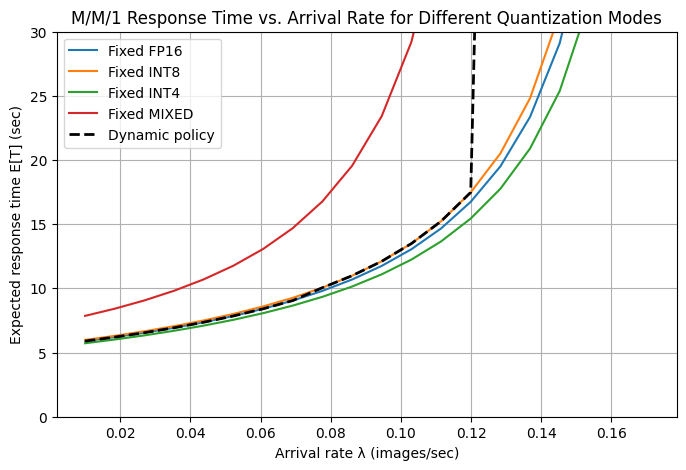

In [12]:
# === CELL: M/M/1 queueing model based on measured latencies ===
import numpy as np
import matplotlib.pyplot as plt

def service_rate_from_latency(latency_s: float) -> float:
    """Service rate μ (jobs per second) from mean latency per image."""
    return 1.0 / latency_s if latency_s > 0 else 0.0

service_rates = {
    mode: service_rate_from_latency(results[mode]["latency"])
    for mode in ["fp16", "int8", "int4", "mixed"]
}

print("Service rates (μ in images/sec):")
for mode, mu in service_rates.items():
    print(f"{mode.upper()}: μ ≈ {mu:.3f}")


def mm1_response_time(lam: float, mu: float) -> float:
    """
    M/M/1 expected response time:
    E[T] = 1 / (μ - λ),  valid only for λ < μ (stable system).
    """
    if lam >= mu:
        return float("inf")
    return 1.0 / (mu - lam)


def choose_mode_dynamic(lam: float, service_rates: dict) -> str:
    """
    Simple dynamic precision policy:
    - For low load, prefer high quality (FP16).
    - For medium load, use INT8.
    - For high load, use mixed or INT4.

    Here we define thresholds based on the FP16 capacity.
    """
    mu_fp16 = service_rates["fp16"]
    if mu_fp16 <= 0:
        # fallback: if FP16 is not valid, just pick INT8
        return "int8"

    rho = lam / mu_fp16  # utilisation relative to FP16 capacity

    if rho < 0.4:
        return "fp16"
    elif rho < 0.7:
        return "int8"
    elif rho < 0.9:
        return "mixed"
    else:
        return "int4"


# Sweep arrival rates from very low up to close to FP16 capacity
max_lambda = service_rates["fp16"] * 0.95 if service_rates["fp16"] > 0 else 1.0
lambda_values = np.linspace(0.01, max_lambda, 20)

response_fixed = {mode: [] for mode in ["fp16", "int8", "int4", "mixed"]}
response_dynamic = []

for lam in lambda_values:
    # Fixed modes
    for mode in response_fixed:
        mu = service_rates[mode]
        T = mm1_response_time(lam, mu) if mu > 0 and lam < mu else float("inf")
        response_fixed[mode].append(T)

    # Dynamic mode
    chosen_mode = choose_mode_dynamic(lam, service_rates)
    mu_chosen = service_rates[chosen_mode]
    T_dyn = mm1_response_time(lam, mu_chosen) if mu_chosen > 0 and lam < mu_chosen else float("inf")
    response_dynamic.append(T_dyn)


# Plot theoretical response times
plt.figure(figsize=(8, 5))
for mode, curve in response_fixed.items():
    plt.plot(lambda_values, curve, label=f"Fixed {mode.upper()}")

plt.plot(lambda_values, response_dynamic, "k--", linewidth=2.0, label="Dynamic policy")

plt.xlabel("Arrival rate λ (images/sec)")
plt.ylabel("Expected response time E[T] (sec)")
plt.title("M/M/1 Response Time vs. Arrival Rate for Different Quantization Modes")
plt.ylim(0, min(30, max([c for curve in response_fixed.values() for c in curve if np.isfinite(c)] + response_dynamic)))
plt.grid(True)
plt.legend()
plt.show()


## Conclusion

This notebook successfully reproduces the essential ideas of Q-Diffusion using the Diffusers library:

- Implemented timestep-aware activation calibration  
- Added fake quantization (INT8, INT4, mixed) to all UNet Conv2d layers  
- Measured latency, memory, and quality impact per mode  
- Modeled system-level behavior using an M/M/1 queue  
- Showed how dynamic precision policies can adapt to load conditions

The results align with our **project proposal** and demonstrate how quantization can significantly improve inference efficiency while enabling intelligent runtime switching policies.


## Limitations

- Fake quantization instead of true hardware INT4 kernels

- Calibration only on a small prompt set

- Stable Diffusion v1.5 is heavy; future work could use smaller models